In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import random
import pandas as pd
import ntpath

In [ ]:
datadir = '/content/track'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'))
data.head()

C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  \
0  C:\Users\Amer\Desktop\new_track\IMG\center_201...                       
1  C:\Users\Amer\Desktop\new_track\IMG\center_201...                       
2  C:\Users\Amer\Desktop\new_track\IMG\center_201...                       
3  C:\Users\Amer\Desktop\new_track\IMG\center_201...                       
4  C:\Users\Amer\Desktop\new_track\IMG\center_201...                       

  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg  \
0  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...                     
1  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...                     
2  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...                     
3  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...                     
4  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...                     

  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg    0  \
0  C:\Users\Amer\Desktop\new_track\IMG\right_2018...                     0.0   
1  C:\Users\Amer\Desktop\new_track\IMG\right_2018...                     0.0   
2  C:\Users\Amer\Desktop\new_track\IMG\right_2018...                     0.0   
3  C:\Users\Amer\Desktop\new_track\IMG\right_2018...                     0.0   
4  C:\Users\Amer\Desktop\new_track\IMG\right_2018...                     0.0   

   0.1  0.2  0.6497864  
0  0.0  0.0   0.627942  
1  0.0  0.0   0.622910  
2  0.0  0.0   0.619162  
3  0.0  0.0   0.615438  
4  0.0  0.0   0.610506

In [ ]:
import os
import pandas as pd
import ntpath

datadir = '/content/track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

# Read the CSV file without headers
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), header=None)

# Manually set the column names
data.columns = columns

# Print the columns to check
print("Columns in CSV file:", data.columns)

# Define the function to extract the leaf of a path
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

# Apply the function to the relevant columns
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

# Display the first few rows of the DataFrame
data.head()


Columns in CSV file: Index(['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'], dtype='object')


center                              left  \
0  center_2018_07_16_17_11_43_382.jpg  left_2018_07_16_17_11_43_382.jpg   
1  center_2018_07_16_17_11_43_670.jpg  left_2018_07_16_17_11_43_670.jpg   
2  center_2018_07_16_17_11_43_724.jpg  left_2018_07_16_17_11_43_724.jpg   
3  center_2018_07_16_17_11_43_792.jpg  left_2018_07_16_17_11_43_792.jpg   
4  center_2018_07_16_17_11_43_860.jpg  left_2018_07_16_17_11_43_860.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_07_16_17_11_43_382.jpg       0.0       0.0      0.0  0.649786  
1  right_2018_07_16_17_11_43_670.jpg       0.0       0.0      0.0  0.627942  
2  right_2018_07_16_17_11_43_724.jpg       0.0       0.0      0.0  0.622910  
3  right_2018_07_16_17_11_43_792.jpg       0.0       0.0      0.0  0.619162  
4  right_2018_07_16_17_11_43_860.jpg       0.0       0.0      0.0  0.615438

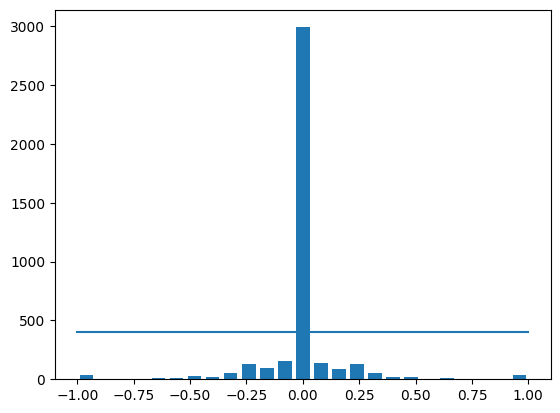

In [ ]:
num_bins = 25
samples_per_bin = 400
hist,bins = np.histogram(data['steering'],num_bins)
center = (bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width=0.06)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [ ]:
print('total data : ',len(data))
print(data.shape)

total data :  4053
(4053, 7)


In [ ]:
!pip install shuffle

In [ ]:
!pip install scikit-learn


In [ ]:
from sklearn.utils import shuffle

remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed data:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining data:', len(data))


removed data: 2590
remaining data: 1463


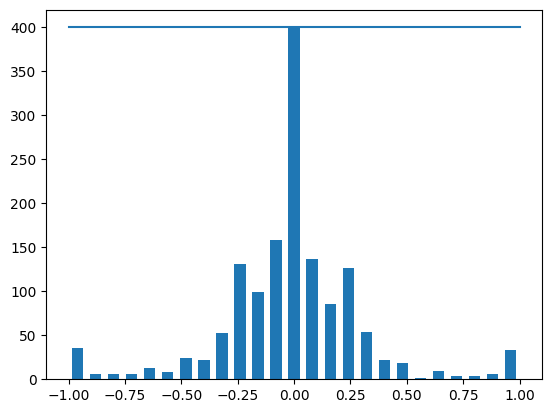

In [ ]:
hist,_ = np.histogram(data['steering'],num_bins)
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [ ]:
def load_img_steering(datadir,df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center = indexed_data[0]
    left = indexed_data[1]
    right = indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))

    # for left
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)

    # for right
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths,steerings


In [ ]:
image_path,steerings = load_img_steering(datadir+'/IMG',data)

In [ ]:
len(image_path)

4389

In [ ]:
len(steerings)

array([ 0.  ,  0.15, -0.15, ...,  0.  ,  0.15, -0.15])

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(image_path,steerings,test_size=0.2,random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train),len(X_valid)))

Training Samples: 3511
Valid Samples: 878


Text(0.5, 1.0, 'Validation set')

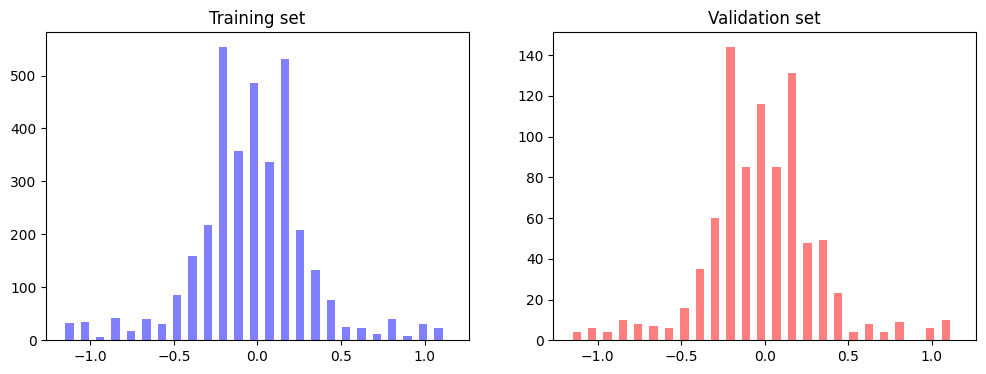

In [ ]:
fig,axes = plt.subplots(1,2,figsize= (12,4))
axes[0].hist(y_train,bins=num_bins,width=0.05,color='blue',alpha=0.5)
axes[0].set_title('Training set')
axes[1].hist(y_valid,bins=num_bins,width=0.05,color='red',alpha=0.5)
axes[1].set_title('Validation set')

Text(0.5, 1.0, 'Zoomed Image')

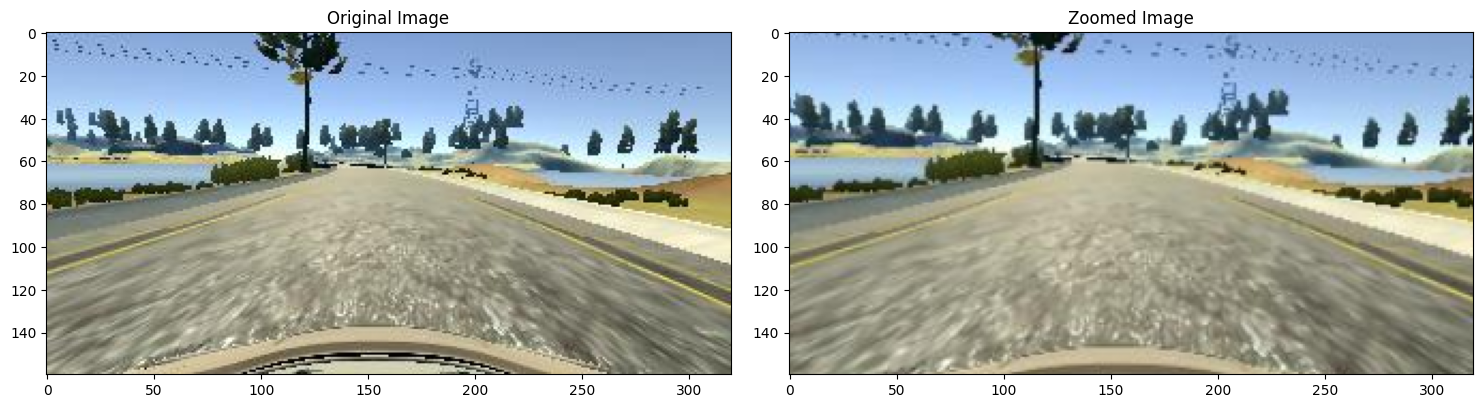

In [ ]:
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.2))
  image = zoom.augment_image(image)
  return image

image = image_path[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(zoomed_image)
axes[1].set_title('Zoomed Image')

Text(0.5, 1.0, 'Panned Image')

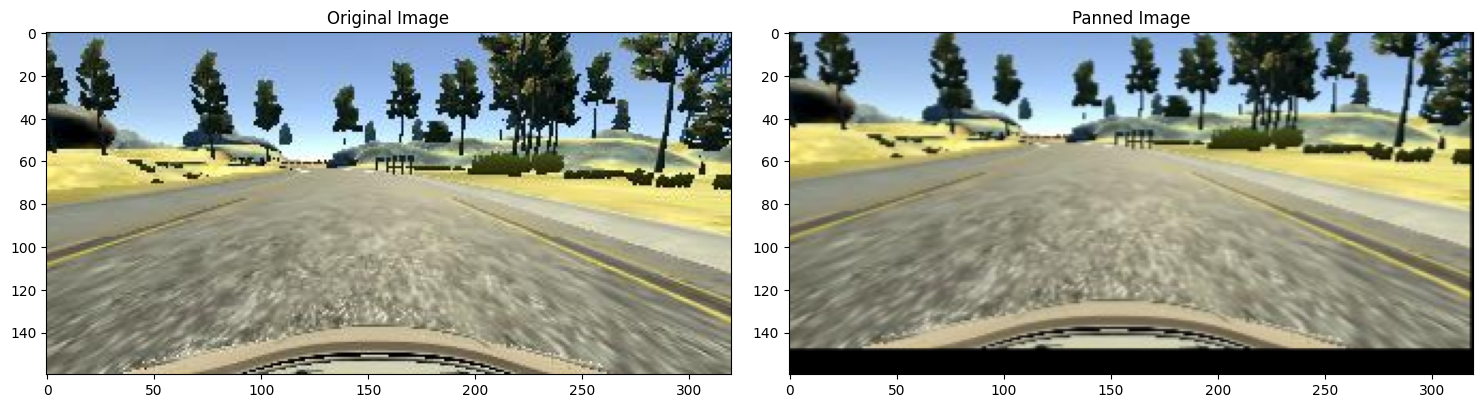

In [ ]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x":(-0.1,0.1),"y":(-0.1,0.1)})
  image = pan.augment_image(image)
  return image
image = image_path[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(panned_image)
axes[1].set_title('Panned Image')

Text(0.5, 1.0, 'Brightened Image')

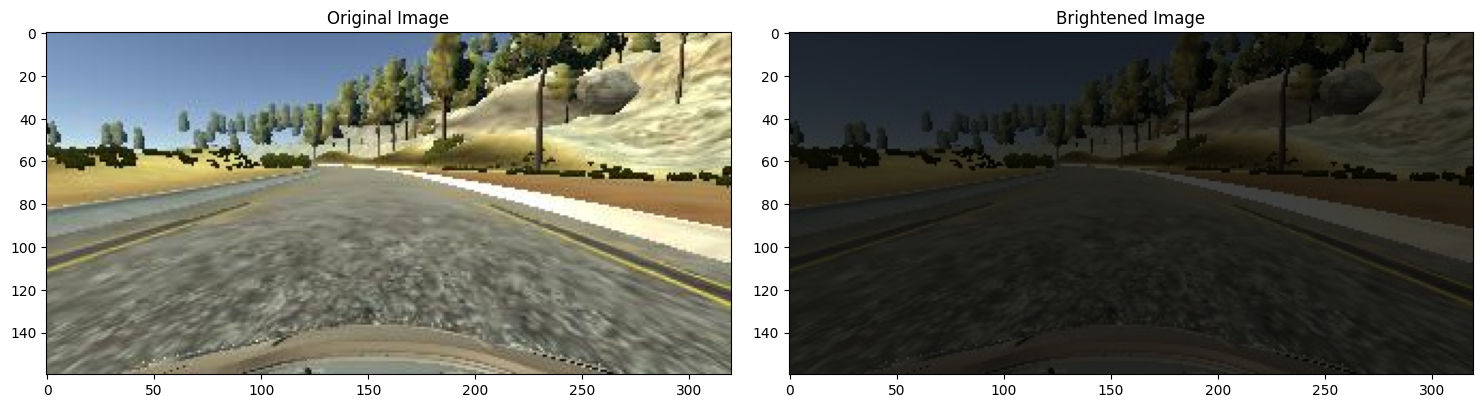

In [ ]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

image = image_path[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightened_image = img_random_brightness(original_image)

fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(brightened_image)
axes[1].set_title('Brightened Image')

Text(0.5, 1.0, 'Flipped Image')

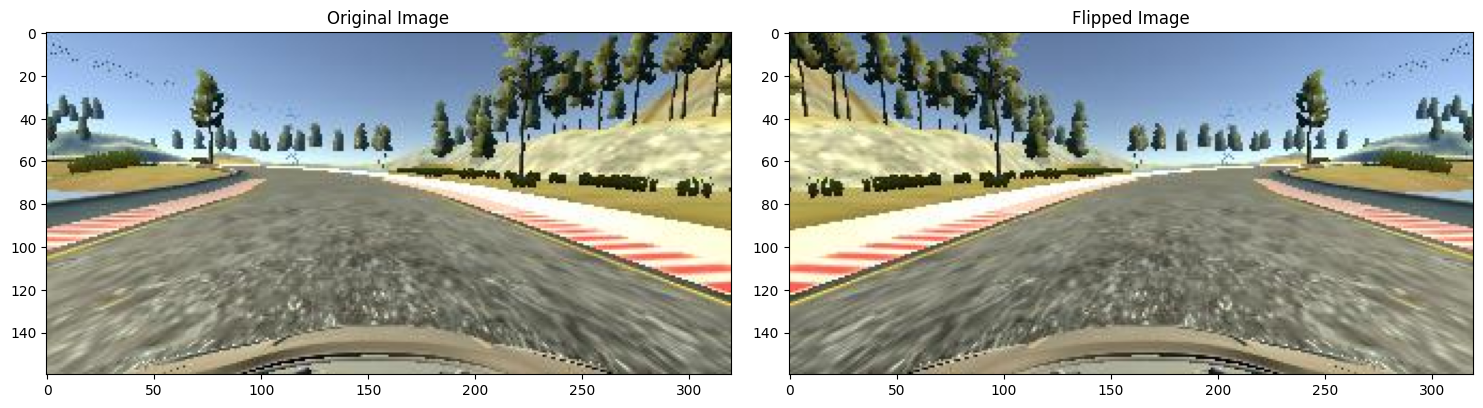

In [ ]:
def img_random_flip(image,steering_angle):
  image = cv2.flip(image,1)
  steering_angle = -steering_angle
  return image,steering_angle
random_index = random.randint(0,1000)
image = image_path[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image,steering = img_random_flip(original_image,steering_angle)

fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(flipped_image)
axes[1].set_title('Flipped Image')

In [ ]:
def random_augment(image,steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image,steering_angle = img_random_flip(image,steering_angle)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  return image,steering_angle

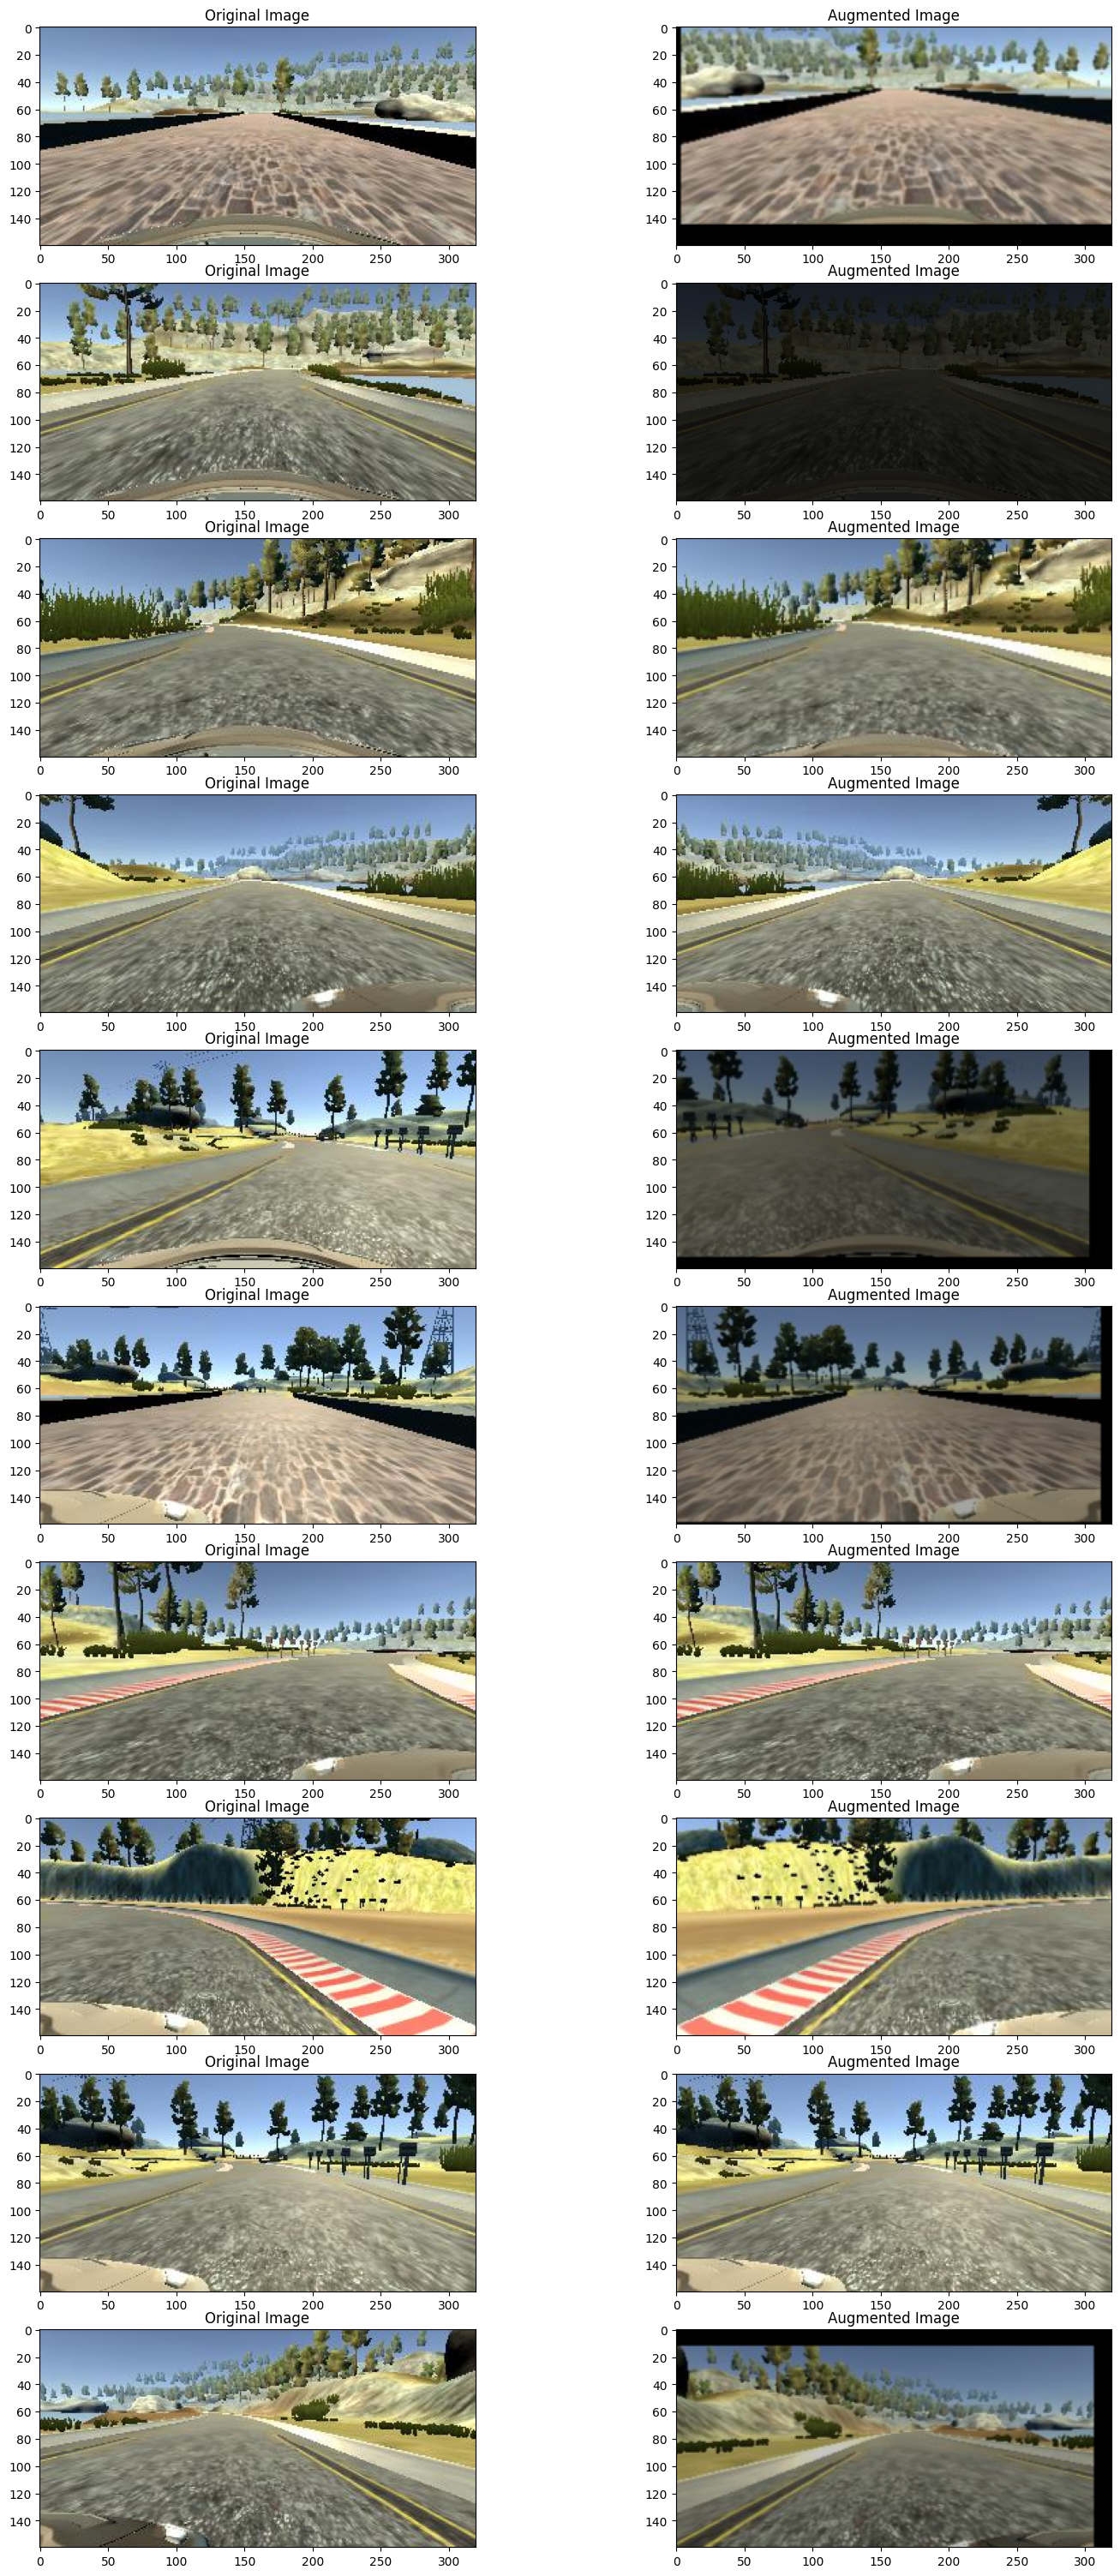

In [ ]:
ncol = 2;
nrow = 10
fig,axes = plt.subplots(nrow,ncol,figsize=(15,30))
fig.tight_layout()

for i in range(nrow):
  randnum = random.randint(0,len(image_path)-1)
  random_image = image_path[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image,steering = random_augment(random_image,random_steering)

  axes[i][0].imshow(original_image)
  axes[i][0].set_title('Original Image')
  axes[i][1].imshow(augmented_image)
  axes[i][1].set_title('Augmented Image')


In [ ]:
def img_preprocess(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,(3,3),0)
  img = cv2.resize(img,(200,66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

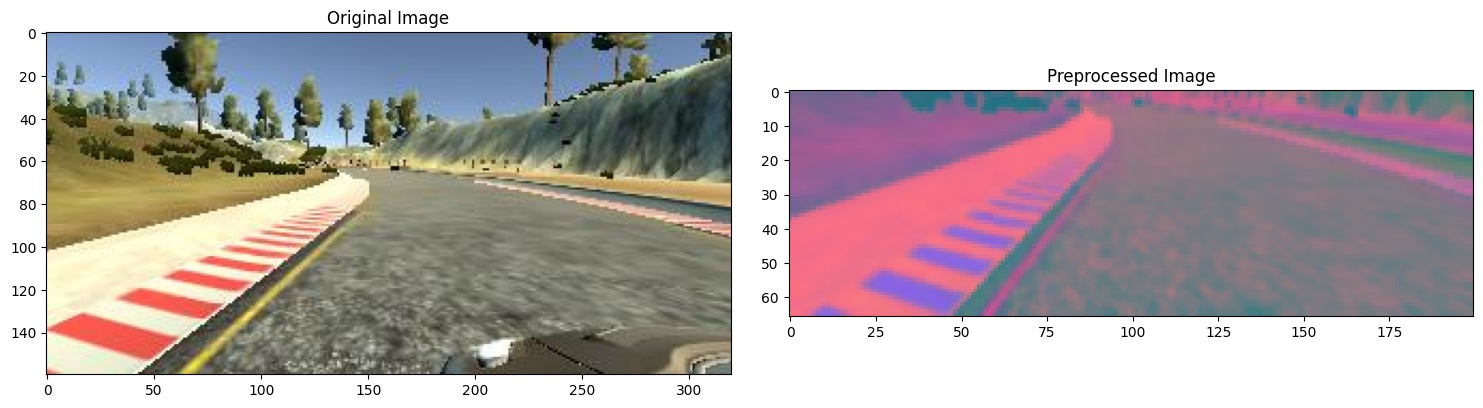

In [ ]:
image = image_path[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [ ]:
!pip install nvidia

ERROR: Could not find a version that satisfies the requirement nvidia (from versions: none)
ERROR: No matching distribution found for nvidia


In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0,len(image_paths)-1)
      if istraining:
        im,steering = random_augment(image_paths[random_index],steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img),np.asarray(batch_steering))


In [ ]:
x_train_gen,y_train_gen = next(batch_generator(X_train,y_train,1,1))
x_valid_gen,y_valid_gen = next(batch_generator(X_valid,y_valid,1,0))

Text(0.5, 1.0, 'Validation Image')

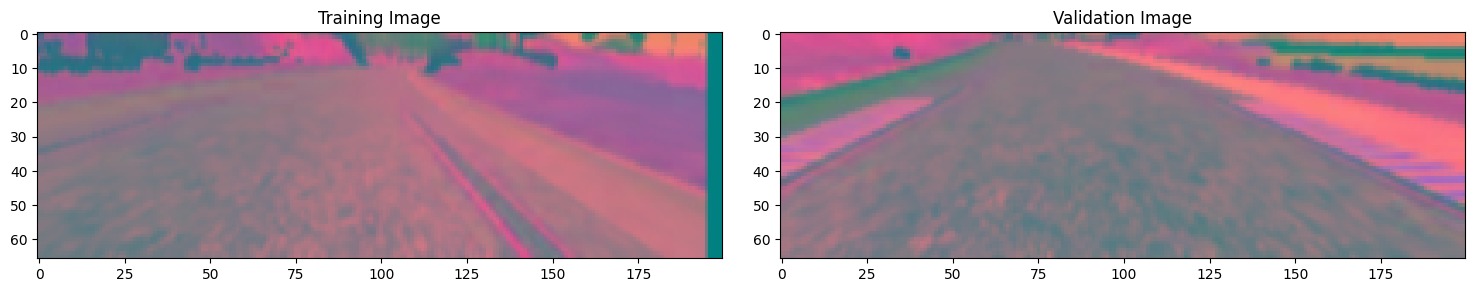

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(x_train_gen[0])
axes[0].set_title('Training Image')
axes[1].imshow(x_valid_gen[0])
axes[1].set_title('Validation Image')

In [ ]:
import tensorflow as tf
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24,(5,5),strides=(2,2),input_shape=(66,200,3),activation='elu'))
  model.add(Conv2D(36,(5,5),strides=(2,2),activation='elu'))
  model.add(Conv2D(48,(5,5),strides=(2,2),activation='elu'))
  model.add(Conv2D(64,(3,3),activation='elu'))


  model.add(Flatten())
  model.add(Dense(100,activation='elu'))
  model.add(Dense(50,activation='elu'))
  model.add(Dense(10,activation='elu'))

  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse',optimizer=optimizer)
  return model
model = nvidia_model()
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 100)               384100    
                                                                 
 dense_1 (Dense)             (None, 50)                5

In [ ]:
history = model.fit(
    batch_generator(X_train, y_train, 100, 1),
    steps_per_epoch=300,
    epochs=10,
    validation_data=batch_generator(X_valid, y_valid, 100, 0),
    validation_steps=200,
    verbose=1,
    shuffle=True
)


Epoch 1/10
300/300 [==============================] - 424s 1s/step - loss: 0.1845 - val_loss: 0.0670
Epoch 2/10
300/300 [==============================] - 378s 1s/step - loss: 0.0757 - val_loss: 0.0608
Epoch 3/10
300/300 [==============================] - 382s 1s/step - loss: 0.0693 - val_loss: 0.0531
Epoch 4/10
300/300 [==============================] - 376s 1s/step - loss: 0.0542 - val_loss: 0.0453
Epoch 5/10
300/300 [==============================] - 373s 1s/step - loss: 0.0498 - val_loss: 0.0463
Epoch 6/10
300/300 [==============================] - 378s 1s/step - loss: 0.0424 - val_loss: 0.0369
Epoch 7/10
300/300 [==============================] - 423s 1s/step - loss: 0.0403 - val_loss: 0.0341
Epoch 8/10
300/300 [==============================] - 360s 1s/step - loss: 0.0378 - val_loss: 0.0350
Epoch 9/10
300/300 [==============================] - 363s 1s/step - loss: 0.0368 - val_loss: 0.0334
Epoch 10/10
300/300 [==============================] - 364s 1s/step - loss: 0.0372 - val_lo

Text(0.5, 0, 'epoch')

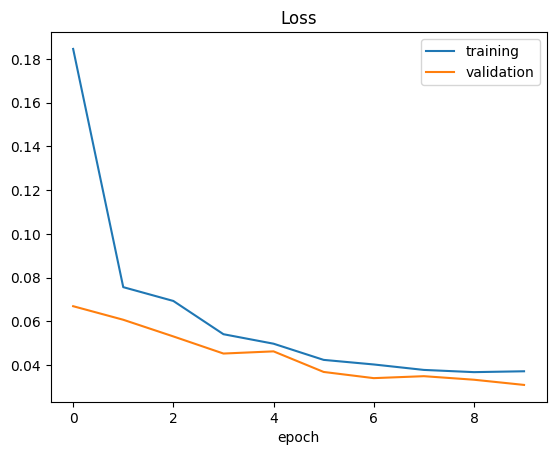

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')

In [ ]:
model.save('model.h5')
from google.colab import files
files.download('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>